<a href="https://colab.research.google.com/github/AiProcess/Pendulum_PPO/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone Repository

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/colab_projects/

/content/gdrive/MyDrive/colab_projects


In [ ]:
!git clone https://github.com/AiProcess/Pendulum_PPO.git

In [3]:
%cd Pendulum_PPO/

/content/gdrive/MyDrive/colab_projects/Pendulum_PPO


In [4]:
!ls

Agent.py  Environment.py  log  main_colab.ipynb  main.ipynb  main.py  __pycache__  README.md


# Installing libraries

In [ ]:
!pip install torchrl
!pip install gym[mujoco]
!pip install av
!apt-get install -y xvfb
!pip install pyvirtualdisplay

In [6]:
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

# Set Device

In [7]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Selected device is {device}')

Selected device is cuda


# Hyperparameters

In [8]:
num_cells = 256
lr = 3e-4
max_grad_norm = 1.0

## Data collection parameters

In [9]:
frame_skips = 0
frames_per_batch = 1000
# For a complete training, bring the number of frames up to 1M
total_frames = 1000_000

## PPO parameters

In [10]:
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Environment

In [11]:
from Environment import EnvSetup, renderEnv
from torchrl.envs import check_env_specs
from torchrl.envs.utils import RandomPolicy

In [12]:
env_setup = EnvSetup(env_name="InvertedDoublePendulum-v4", device=device)
env = env_setup.create_main_env()
test_env = env_setup.create_test_env()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
check_env_specs(env)
check_env_specs(test_env)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2024-11-22 19:00:19,290 [torchrl][INFO] check_env_specs succeeded!
2024-11-22 19:00:19,362 [torchrl][INFO] check_env_specs succeeded!


In [14]:
renderEnv(env=test_env, max_steps=1000, policy=RandomPolicy(test_env.action_spec))

# Agent

In [15]:
from Agent import PPOAgent

In [16]:
agent = PPOAgent(
    device=device, num_cells=num_cells, env=env,
    frames_per_batch=frames_per_batch, total_frames=total_frames,
    clip_epsilon=clip_epsilon, entropy_eps=entropy_eps, gamma=gamma,
    lmbda=lmbda, learning_rate=lr, num_epochs=num_epochs,
    sub_batch_size=sub_batch_size, max_grad_norm=max_grad_norm
)
policy_module = agent.policy_module
value_module = agent.value_module

In [17]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True),
        terminated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        truncated: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_sh

In [18]:
agent.train()

eval cumulative reward:  9358.9785 (init:  92.0113), eval step-count: 999, average reward= 9.3590 (init= 9.0889), step count (max): 999, lr policy:  0.0000: 100%|██████████| 1000000/1000000 [1:08:23<00:00, 243.71it/s]


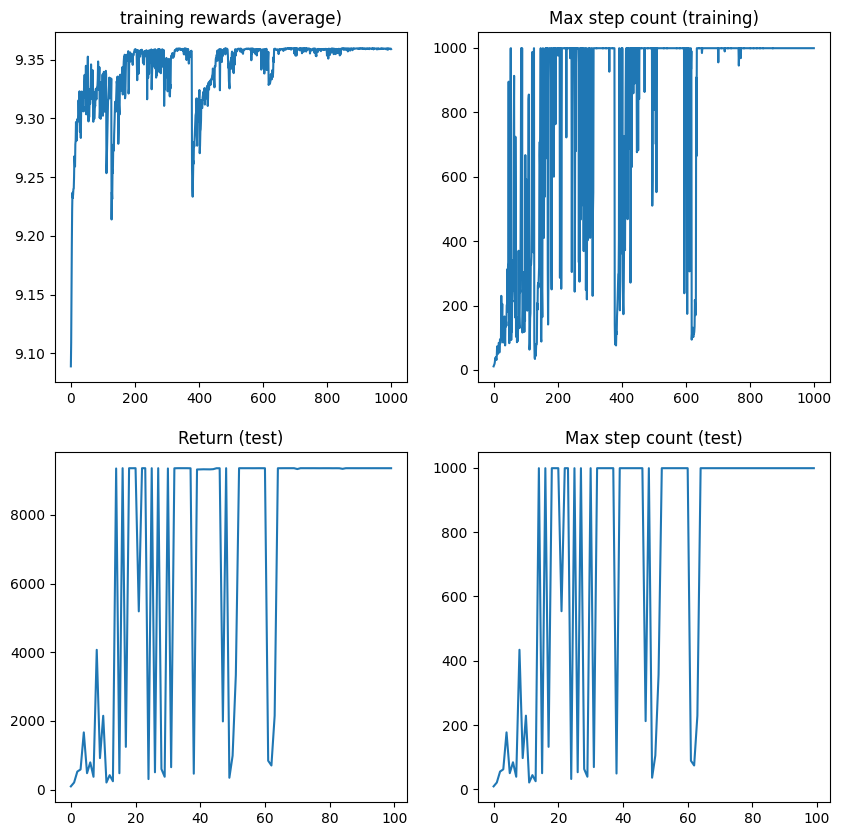

In [19]:
agent.plot_results()

In [21]:
renderEnv(env=test_env, max_steps=1000, policy=agent.policy_module)